# Multimodal RAG 🔍

Dev Info:
- Embedding Dimension of gemini model: 768

# Phase 0 (Package Installations 💽)

In [ ]:
!apt-get -qq install poppler-utils tesseract-ocr
!apt-get -qq install ffmpeg
%pip install -q --user --upgrade pillow
%pip install -q unstructured["pdf"]

!pip install --quiet -U langchain-text-splitters tiktoken

!pip install --quiet -U google-generativeai

!pip install pymongo

In [ ]:
# Install NLTK Data
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

# Phase 1.1 (Extraction of PDFs 📰 - Text & Image data):

- Upload PDF
- Extract text & images from PDF using `unstructured`
- Split the text chunks based on token limit
- Generate text embeddings for texts splitted
- Generate image summary within token limit using LLM by passing image to Vision LLM `gemini`
- Generate text embeddings for summary generated

In [ ]:
!mkdir -p pdfs
!mkdir -p images
!mkdir -p audios

In [ ]:
from unstructured.partition.pdf import partition_pdf
import os
from langchain_text_splitters import RecursiveCharacterTextSplitter
import base64
from google.colab import userdata
import google.generativeai as genai
import PIL.Image
import subprocess

In [ ]:
GOOGLE_API_KEY=userdata.get('GOOGLE_API_KEY')

text_embedding_model = "models/text-embedding-004"
text_embedding_model_for_text_splitting = "text-embedding-3-small" # since encoding of models/text-embedding-004 isn't available yet
llm_model = 'gemini-1.5-flash'
pdfs_folder_path = '/content/pdfs'
images_folder_path = '/content/images'
audios_folder_path = '/content/audios'
extracted_pdfs = []
extracted_audios = []
texts_to_embed = []
images_to_embed = []
prompt = "Please convert audio into text and give descriptive summary it has. Make sure it includes all information it had."

text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    model_name=text_embedding_model_for_text_splitting,
    chunk_size=150,
    chunk_overlap=0,
)

genai.configure(api_key=GOOGLE_API_KEY)
gemini_model = genai.GenerativeModel(model_name=llm_model)

In [ ]:
for pdf_file in sorted(os.listdir(pdfs_folder_path)):
  pdf_path = os.path.join(pdfs_folder_path, pdf_file)
  print("Extracting content from PDF - " + pdf_path)
  try:
    extracted_pdfs.append({
        "chunks": partition_pdf(pdf_path,
            extract_images_in_pdf=True,
            extract_image_block_output_dir=os.path.join(images_folder_path, pdf_file)),
        "filename": pdf_file
      }
    )
  except PIL.UnidentifiedImageError as e:
    print(f"Error processing {pdf_file}: {e}")

Extracting content from PDF - /content/pdfs/gym_supps.pdf
Extracting content from PDF - /content/pdfs/mm_rag.pdf


In [ ]:
[len(extracted_pdfs[i]['chunks']) for i in range(len(extracted_pdfs))]

[41, 15]

In [ ]:
for extracted_pdf in extracted_pdfs:
  total_chunks = len(extracted_pdf.get('chunks'))

  for index, chunk in enumerate(extracted_pdf.get('chunks')):
    print(f'Processing chunk {index+1}/{total_chunks} of {extracted_pdf.get("filename")}');

    if chunk.category != "Image":
      splitted_text = text_splitter.split_text(chunk.text)
      texts_to_embed.extend([{
          "type": "text",
          "filename": extracted_pdf.get('filename'),
          "text": text,
          "embedding": genai.embed_content(model=text_embedding_model, content=text)['embedding']} for text in splitted_text])

Processing chunk 1/41 of gym_supps.pdf
Processing chunk 2/41 of gym_supps.pdf
Processing chunk 3/41 of gym_supps.pdf
Processing chunk 4/41 of gym_supps.pdf
Processing chunk 5/41 of gym_supps.pdf
Processing chunk 6/41 of gym_supps.pdf
Processing chunk 7/41 of gym_supps.pdf
Processing chunk 8/41 of gym_supps.pdf
Processing chunk 9/41 of gym_supps.pdf
Processing chunk 10/41 of gym_supps.pdf
Processing chunk 11/41 of gym_supps.pdf
Processing chunk 12/41 of gym_supps.pdf
Processing chunk 13/41 of gym_supps.pdf
Processing chunk 14/41 of gym_supps.pdf
Processing chunk 15/41 of gym_supps.pdf
Processing chunk 16/41 of gym_supps.pdf
Processing chunk 17/41 of gym_supps.pdf
Processing chunk 18/41 of gym_supps.pdf
Processing chunk 19/41 of gym_supps.pdf
Processing chunk 20/41 of gym_supps.pdf
Processing chunk 21/41 of gym_supps.pdf
Processing chunk 22/41 of gym_supps.pdf
Processing chunk 23/41 of gym_supps.pdf
Processing chunk 24/41 of gym_supps.pdf
Processing chunk 25/41 of gym_supps.pdf
Processin

In [ ]:
# texts_to_embed
print(len(texts_to_embed))

47


In [ ]:
def encode_image(image_path):
    with open(image_path, "rb") as image_file:
        return base64.b64encode(image_file.read()).decode('utf-8')

for folder in sorted(os.listdir(images_folder_path)):
  file_imgs_folder = os.path.join(images_folder_path, folder)

  for img_file in sorted(os.listdir(file_imgs_folder)):
    encoded_image = encode_image(os.path.join(file_imgs_folder, img_file))

    print("Summarizing & embedding image - " + os.path.join(file_imgs_folder, img_file))
    raw_img = PIL.Image.open(os.path.join(file_imgs_folder, img_file))
    gemini_res = gemini_model.generate_content(["Give a brief description of attached image to store it in Vector Database for RAG Search within 100 tokens. Also specify its an image so that RAG can understand its an image description", raw_img])
    images_to_embed.append({
        "type": "image",
        "base64_image": encoded_image,
        "filename": folder,
        "text": gemini_res.text,
        "embedding": genai.embed_content(model=text_embedding_model, content=gemini_res.text)['embedding']
        })


Summarizing & embedding image - /content/images/gym_supps.pdf/figure-1-1.jpg
Summarizing & embedding image - /content/images/gym_supps.pdf/figure-1-2.jpg
Summarizing & embedding image - /content/images/gym_supps.pdf/figure-1-3.jpg
Summarizing & embedding image - /content/images/gym_supps.pdf/figure-3-4.jpg
Summarizing & embedding image - /content/images/gym_supps.pdf/figure-3-5.jpg
Summarizing & embedding image - /content/images/gym_supps.pdf/figure-3-6.jpg
Summarizing & embedding image - /content/images/gym_supps.pdf/figure-3-7.jpg
Summarizing & embedding image - /content/images/mm_rag.pdf/figure-1-1.jpg
Summarizing & embedding image - /content/images/mm_rag.pdf/figure-2-2.jpg


In [ ]:
images_to_embed[0]["text"]
# print(len(images_to_embed))

'Image of a black tub of Optimum Nutrition Micronised Creatine powder. The tub is labeled with the product name, brand, and weight. It is a supplement for performance support.'

# Phase 1.2 (Extraction of Audios 🔊 - Audio data):

- Upload Audios
- Convert them to .opus
- Pass it to Audio Model(gemini) and get txion
- Split the txion into chunks based on tokens
- Generate text embeddings for txion splitted

In [ ]:
def hit_gemini_for_audio(audio_path):
  try:
    print(f"Transcribig {audio_path}")
    audio_file = genai.upload_file(path=audio_path)

    response = gemini_model.generate_content([prompt, audio_file])

    genai.delete_file(audio_file.name)

    return response.text
  except Exception as e:
    print(f"Error processing {audio_path}: {e}")
    return None


for audio_file in sorted(os.listdir(audios_folder_path)):
  audio_path = os.path.join(audios_folder_path, audio_file)
  audio_path_converted = audio_path.replace(audios_folder_path, "/tmp")
  splitted_temp = audio_path_converted.split('.')[0:-1]
  audio_path_converted = "".join(splitted_temp) + ".opus"

  print(f"Converting {audio_file} to .opus ...")
  command = ["ffmpeg", "-i", audio_path, audio_path_converted]
  subprocess.run(command, check=True)

  try:
    print("Extracting content from Audio - " + audio_path_converted)
    txion = hit_gemini_for_audio(audio_path_converted)
    if txion is not None:
      extracted_audios.append({
        "filename": audio_file,
        "text": txion
      })
    print(f"Finished processing {audio_path_converted}")
    os.remove(audio_path_converted)
    print(f"Cleaned up {audio_path_converted} \n \n")
  except Exception as e:
    print(f"Error processing {audio_file}: {e}")


for extracted_audio in extracted_audios:
  print("Splitting and embedding Audio - " + extracted_audio.get('filename'))
  splitted_text = text_splitter.split_text(extracted_audio.get('text'))
  texts_to_embed.extend([{
      "type": "audio",
      "filename": extracted_audio.get('filename'),
      "text": text,
      "embedding": genai.embed_content(model=text_embedding_model, content=text)['embedding']} for text in splitted_text])
  print(f"Finished processing {extracted_audio.get('filename')}")

# Phase 2 (Storing Embeddings in DB 🥫):

- Create a vector search index in mongoDB
- Store text & embeddings in MongoDB Vector Store

In [ ]:
from pymongo import MongoClient

client = MongoClient(userdata.get('MONGODB_URI'))
collection = client['mm_rag']['pdfs']

In [ ]:
print(f'Inserting {len(texts_to_embed) + len(images_to_embed)} records')
collection.insert_many(texts_to_embed)
collection.insert_many(images_to_embed)

Inserting 59 records


InsertManyResult([ObjectId('669cceeb21d2bddfb9717a64'), ObjectId('669cceeb21d2bddfb9717a65'), ObjectId('669cceeb21d2bddfb9717a66'), ObjectId('669cceeb21d2bddfb9717a67'), ObjectId('669cceeb21d2bddfb9717a68'), ObjectId('669cceeb21d2bddfb9717a69'), ObjectId('669cceeb21d2bddfb9717a6a'), ObjectId('669cceeb21d2bddfb9717a6b'), ObjectId('669cceeb21d2bddfb9717a6c')], acknowledged=True)

In [ ]:
len(list(collection.find()))

59

# Phase 3 (RAG in action - Fetch relevant docs 🔍):

- Take user query
- Generate embedding vector for it
- Query it against Vector Storage and pull top `5` matches

In [ ]:
# user_query = input("Enter your query: ")
"""
PDFs loaded => mm_rag.pdf, gym_supps.pdf
Audios loaded => resistance_vs_weight_training.mp3, lean_bulking.mp3
"""


user_query = "How to do lean bulking?"

🔴 🔴 🔴 Helpers - Start: 🔴 🔴 🔴

In [ ]:
# collection.delete_many({})

In [ ]:
# !pip install --quiet -U google-generativeai
# !pip install pymongo

# from google.colab import userdata
# import google.generativeai as genai
# from pymongo import MongoClient

# text_embedding_model = "models/text-embedding-004"
# llm_model = 'gemini-1.5-flash'
# GOOGLE_API_KEY = userdata.get('GOOGLE_API_KEY')

# genai.configure(api_key=GOOGLE_API_KEY)
# gemini_model = genai.GenerativeModel(llm_model)

# client = MongoClient(userdata.get('MONGODB_URI'))
# collection = client['mm_rag']['pdfs']

🔴 🔴 🔴 Helpers - End 🔴 🔴 🔴

In [ ]:
embedded_user_query = genai.embed_content(model=text_embedding_model, content=user_query)['embedding']

print(len(embedded_user_query))

768


In [ ]:
relevant_chunks = list(collection.aggregate([
  {
    "$vectorSearch": {
      "index": "idx_mmrag_pdfs",
      "path": "embedding",
      "queryVector": embedded_user_query,
      "numCandidates": 10,
      "limit": 5
    }
  },
  {
    "$project": {
      "_id": 0,
      "filename": 1,
      "type": 1,
      "text": 1,
      "base64_image": 1,
      "score": { "$meta": "vectorSearchScore" }
    }
  }
]))

In [ ]:
relevant_chunks

[{'type': 'audio',
  'filename': 'lean_bulking.mp3',
  'text': 'This video talks about the concept of "bulking," a strategy of consuming more calories than you would normally expend to fuel muscle growth. The video then goes into detail about "lean bulking," which is a strategy that aims to minimize fat gain while maximizing muscle gains. The video explains that lean bulking requires a more calculated approach to calorie intake, as it is important to not exceed the amount you burn by a large margin, and that it is important to get enough protein. The video also mentions that it is crucial to follow a resistance training program, to adjust your calorie intake based on your ongoing results, and to get most of your food from healthy whole foods. The video ends with a call to action for viewers to join the PictureFit Discord',
  'score': 0.8732060194015503},
 {'type': 'text',
  'filename': 'gym_supps.pdf',
  'text': 'Enhancing Muscle Growth and Performance',
  'score': 0.737373948097229},


# Phase 4 (RAG in action - Augment LLM with relevant docs 🤖):

- Extract `text` field from results obtained
- Pass these extracted `text`'s to LLM along with user query to generate a precise response against user query
- `optional:` In those top `5` results obtained, if there are any images, extract & pass `base64` of them to user saying, they are matched images

In [ ]:
texts_to_llm = []
image_summaries_to_llm = []
base64_images_to_user_query = []

for chunk in relevant_chunks:
  if chunk["type"] == "text" or chunk["type"] == "audio":
    texts_to_llm.append(chunk["text"])
  else:
    image_summaries_to_llm.append(chunk["text"])
    base64_images_to_user_query.append(chunk["base64_image"])

In [ ]:
print(len(texts_to_llm))
texts_to_llm

4


['This video talks about the concept of "bulking," a strategy of consuming more calories than you would normally expend to fuel muscle growth. The video then goes into detail about "lean bulking," which is a strategy that aims to minimize fat gain while maximizing muscle gains. The video explains that lean bulking requires a more calculated approach to calorie intake, as it is important to not exceed the amount you burn by a large margin, and that it is important to get enough protein. The video also mentions that it is crucial to follow a resistance training program, to adjust your calorie intake based on your ongoing results, and to get most of your food from healthy whole foods. The video ends with a call to action for viewers to join the PictureFit Discord',
 'Enhancing Muscle Growth and Performance',
 'can experience significant gains in lean muscle tissue and overall physical performance, making it a go-to supplement for those looking to maximize their workout results.',
 'Beyond

In [ ]:
print(len(image_summaries_to_llm))
image_summaries_to_llm

1


['Image: A bar chart comparing the percentage gains in lean muscle mass, bench press, squat, and negative side effects between creatine and placebo groups during weight training. Creatine had significantly higher gains in lean muscle mass, bench press and squat.  The negative side effects were minimal for both groups.']

In [ ]:
len(base64_images_to_user_query)

1

In [ ]:
llm_prompt = f"""
Here are some relevant passages I found about {user_query}:

{texts_to_llm}

Additionally, these are image summaries found related to the same query:

{image_summaries_to_llm}

Based on the information above, can you provide a short and crisp response to the query?
"""

response_to_user = gemini_model.generate_content([llm_prompt])

Query: How to do lean bulking?
Answer: Lean bulking is a strategy for gaining muscle while minimizing fat gain. It involves carefully calculating calorie intake, getting enough protein, following a resistance training program, and adjusting your diet based on results. Consuming whey protein can contribute to both muscle growth and weight management by promoting satiety, boosting metabolism, and preserving lean muscle during weight loss. 




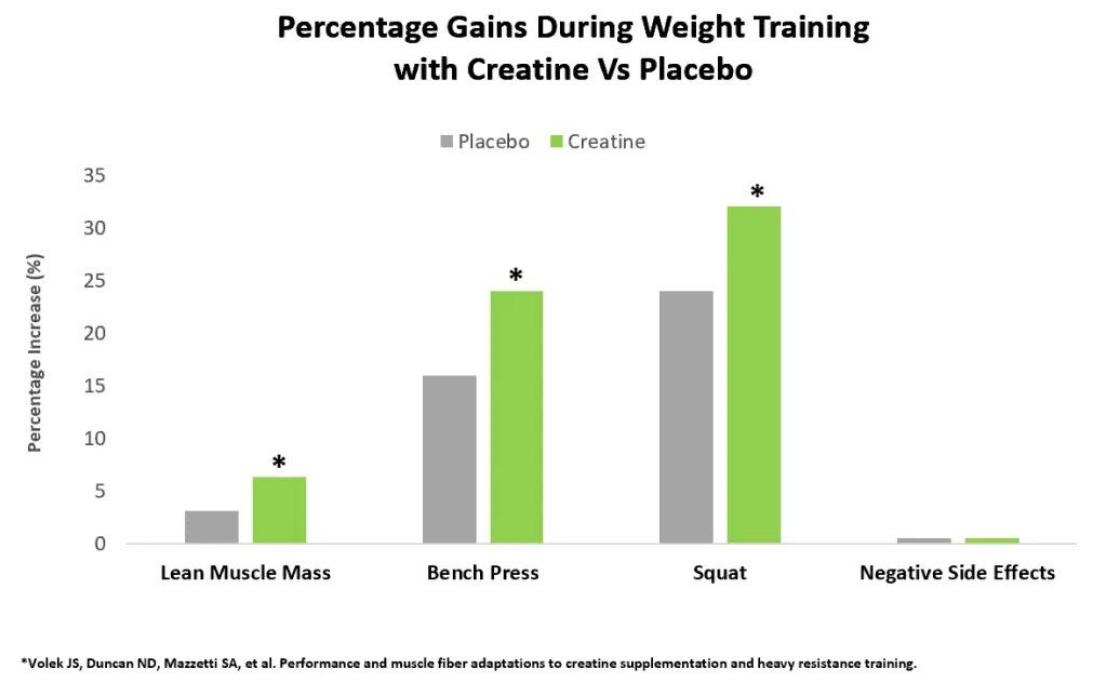

In [ ]:
from IPython import display

images_html = ""
for i in range(len(base64_images_to_user_query)):
  images_html += f'<img src="data:image/png;base64,{base64_images_to_user_query[i]}" />'

print("Query: " + user_query)
print("Answer: " + response_to_user.text)
display.HTML(images_html)

# Phase 5 (Clean up 🛀):

- Clear all file system

In [ ]:
!rm -rf pdfs
!rm -rf images
!rm -rf audios

# The END 😀